In [308]:
!pip install -q transformers
!pip install -q kaggle

# **Required Imports**

In [2]:
from transformers import RobertaTokenizer,RobertaTokenizerFast
from transformers import TFRobertaForSequenceClassification

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

import tensorflow as tf
import json

import numpy as np
import pandas as pd


import os
import re

# **Data Prepration**

In [ ]:
def loadData(Dirpath):
  


In [ ]:
# jsonDataString = "{"
# DataTypes = []
# EmotionData= []
# dataDir = ["data/"]
# for dataList in dataDir:
#   for dirNames in os.listdir(os.path.join(dataList)):
#     jsonDataString+=dirNames+':[{'
#     temp2 = ""
#     for emoDir in os.listdir(os.path.join(dataList,dirNames)):
#       jsonDataString += emoDir+':['
#       for filesName in os.listdir(os.path.join(dataList,dirNames,emoDir)):
#         with open(os.path.join(dataList,dirNames,emoDir, filesName) ,'r') as f:
#           jsonDataString+=re.sub(r"\n", "", f.read())+','
          
#       jsonDataString = jsonDataString[0:len(jsonDataString)-1]+'],'
#     jsonDataString =jsonDataString[0:len(jsonDataString)-1]+'}],'
  

#       # for filesName in os.listdir(os.path.join(dataList,dirNames,emoDir)):
#       #   print('',end='')
#     #with open(os.path.join(os.getcwd(), filename), 'r') as f:
# jsonDataString = jsonDataString[0:len(jsonDataString)-1]+'}' 
# print(jsonDataString)

In [289]:
TestTrainData = json.load(open('/home/data.json'))
TrainData = TestTrainData['train'][0]
TestData = TestTrainData['test'][0]
FormattedTrainData=[]
FormattedTrainLabel=[]
FormattedTestData=[]
FormattedTestLabel=[]

for i in ((TestData)):
  # if((list((TestData.keys())).index(i))<2):
  for ii in TestData[i]:
      FormattedTestData.append([(list((TestData.keys())).index(i)),ii])
      FormattedTestLabel.append(((list((TrainData.keys())).index(i))))

for i in ((TrainData)):
  # if((list((TrainData.keys())).index(i))<2):
  for ii in TrainData[i]:
        FormattedTrainData.append([(list(TrainData.keys()).index(i)),ii])
        FormattedTrainLabel.append((list(TrainData.keys()).index(i)))
maxLen = int(60)
FormattedTrainData = pd.DataFrame(np.array((FormattedTrainData)), columns = ['label','message']).sample(frac = 1)
FormattedTestData =  pd.DataFrame(np.array((FormattedTestData)), columns = ['label','message']).sample(frac = 1)
FormattedTrainData.head()
FormattedTestData.head()


,label,message
1001,3,im thinking well i could be a bit smaller but ...
1017,3,i never feel lonely as long as people love and...
822,3,i often throw myself into work when i m not wi...
603,2,i have come from the summer time and feeling l...
796,3,i don t feel guilty like i m not going to be a...


In [290]:
Xids = np.zeros((len(FormattedTrainData),maxLen))
Xmask = np.zeros((len(FormattedTrainData),maxLen))

In [291]:
training_sentences = list(FormattedTrainData['message'])
validation_sentences = list(FormattedTestData['message'])
training_labels = list(pd.to_numeric(FormattedTrainData['label'], downcast='integer'))
validation_labels =  list(pd.to_numeric(FormattedTestData['label'], downcast='integer'))


In [341]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(training_sentences,
                            truncation=True,max_length=maxLen,
                            padding=True,return_tensors='tf')
val_encodings = tokenizer(validation_sentences,
                            truncation=True,max_length=maxLen,
                            padding=True,return_tensors='tf')
print()


In [343]:
# print(train_encodings['input_ids'])
Xids = train_encodings['input_ids']
Xmask = train_encodings['attention_mask']


In [344]:
newLabels = np.zeros((len(training_labels),pd.to_numeric(FormattedTrainData['label'], downcast='integer').max()+1))

In [345]:
newLabels.shape
newLabels[np.arange(pd.to_numeric(FormattedTrainData['label'], downcast='integer').size),pd.to_numeric(FormattedTrainData['label'], downcast='integer')] = 1
newLabels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [347]:
traindataset = tf.data.Dataset.from_tensor_slices((
    Xids,Xmask,
    newLabels
))

# valdataset = tf.data.Dataset.from_tensor_slices((
#     dict(val_encodings),
#     validation_labels
# ))

In [348]:
print(traindataset)

<TensorSliceDataset shapes: ((60,), (60,), (4,)), types: (tf.int32, tf.int32, tf.float64)>


In [349]:
def mapFun(input_ids,masks,labels):
  return {'input_ids':input_ids,'attention_mask':masks},labels
traindataset=traindataset.map(mapFun)
for i in traindataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(60,), dtype=int32, numpy=
array([    0,   118,   619, 32386,    30,    99,   127,   809,    64,
         326,   109,    53,    77,   127,  1623,   817,  9766,  1567,
         162,    24, 14236,   162,    14,  1135,    70,    14, 15642,
        5741,     7,   185,    31,   127,   301,    37,   202,  5684,
         162,    45,   129,  5912,  6043,    53,  2721,     2,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(60,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([0., 0., 0., 1.])>)


In [350]:
traindataset = traindataset.shuffle(10000).batch(16)

In [351]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    newLabels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))


In [352]:
from transformers import TFAutoModel
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=4)
model2 = TFAutoModel.from_pretrained('roberta-base')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model

In [338]:
input_ids = tf.keras.layers.Input(shape=(maxLen,),name="input_ids", dtype='int32')
mask = tf.keras.layers.Input(shape=(maxLen,),name="attention_mask",dtype='int32')
embeddings = model2(input_ids,attention_mask=mask)[0]
X = tf.keras.layers.GlobalAvgPool1D()(embeddings)
X = tf.keras.layers.Dropout(0.1)(X)
Y = tf.keras.layers.Dense(4,activation='softmax',name='outputs')(X)
testModel = tf.keras.Model(inputs=[input_ids,mask],outputs=Y)


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 tf_roberta_model_10 (TFRoberta  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 Model)                         thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                         

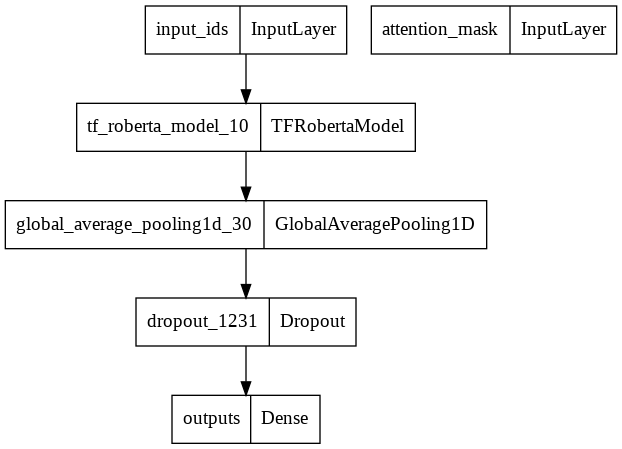

In [331]:
testModel.summary()
tf.keras.utils.plot_model(testModel)

In [353]:
testModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [ ]:
hist = testModel.fit(traindataset,epochs=3)

In [ ]:
input_ids = tf.keras.layers.Input(shape=(maxLen,),name="input_ids", dtype='int32')
mask = tf.keras.layers.Input(shape=(maxLen,),name="attention_mask",dtype='int32')
embeddings = model2(input_ids,attention_mask=mask)[0]
X = tf.keras.layers.GlobalAvgPool1D()(embeddings)
X = tf.keras.layers.Dropout(0.1)(X)
Y = tf.keras.layers.Dense(4,activation='softmax',name='outputs')(X)
testModel = tf.keras.Model(inputs=[input_ids,mask],outputs=Y)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
hist = model.fit(train_dataset.batch(16),
          epochs=1,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


152/543 [=======>......................] - ETA: 2:59 - loss: 1.0325 - accuracy: 0.5473

dict_keys(['loss', 'accuracy'])


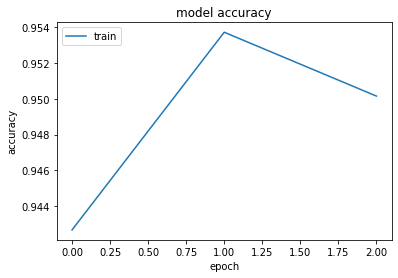

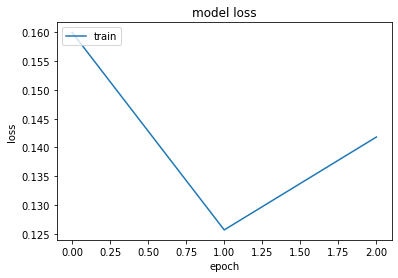

In [190]:
print(hist.history.keys())
plt.plot(hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [195]:
model.summary()
tf.keras.utils.plot_model(model)
model.save('/home/test', hist)


model.save_pretrained('/home/emotion_Model')

Model: "tf_roberta_for_sequence_classification_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 593668    
 ficationHead)                                                   
                                                                 
Total params: 124,648,708
Trainable params: 124,648,708
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: /home/test/assets


INFO:tensorflow:Assets written to: /home/test/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [196]:
from tensorflow.keras.models import load_model
model = load_model('/home/test')

In [ ]:
model.

In [ ]:
!mkdir /home/emotion_Model

In [ ]:
loaded_model = TFRobertaForSequenceClassification.from_pretrained("/home/emotion_Model")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /home/emotion_Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
loaded_model = TFRobertaForSequenceClassification.from_pretrained("/home/emotion_Model")

predict_input =  RobertaTokenizer.from_pretrained('roberta-base').encode(i,
                                truncation=True,
                                padding=True,
                                return_tensors="tf")
tf_output = loaded_model.predict(predict_input)[0]
tf_prediction = list(tf.nn.softmax(tf_output)[0].numpy())
predition = tf_prediction.index((list(tf_prediction)))

# predict_output.append(list(TestData)[predition])
# print(predict_output)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /home/emotion_Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


ValueError: ignored

In [ ]:

predict_output=[]
for i in validation_sentences:
  predict_input = tokenizer.encode(i,
                                  truncation=True,
                                  padding=True,
                                  return_tensors="tf")
  tf_output = loaded_model.predict(predict_input)[0]
  tf_prediction = list(tf.nn.softmax(tf_output)[0].numpy())
  predition = tf_prediction.index(max(list(tf_prediction)))
  predict_output.append(list(TestData)[predition])
print(predict_output)

In [ ]:
true_output = []
for i in list(pd.to_numeric(validation_labels)):
  true_output.append(list(TestData)[i])
#print(true_output)

# print(tf_prediction)
# print(TestData.keys())
# print(TrainData.keys())

In [ ]:
from sklearn.metrics import f1_score
# f1_score(true_output, pimport matplotlib.pyplot as pltredict_output, average='macro')
print(classification_report(true_output, predict_output))

              precision    recall  f1-score   support

       Anger       0.92      0.95      0.93       276
        Fear       0.93      0.96      0.95       225
        Love       0.91      1.00      0.96       160
     Sadness       0.98      0.93      0.95       581

    accuracy                           0.95      1242
   macro avg       0.94      0.96      0.95      1242
weighted avg       0.95      0.95      0.95      1242



In [ ]:


# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')



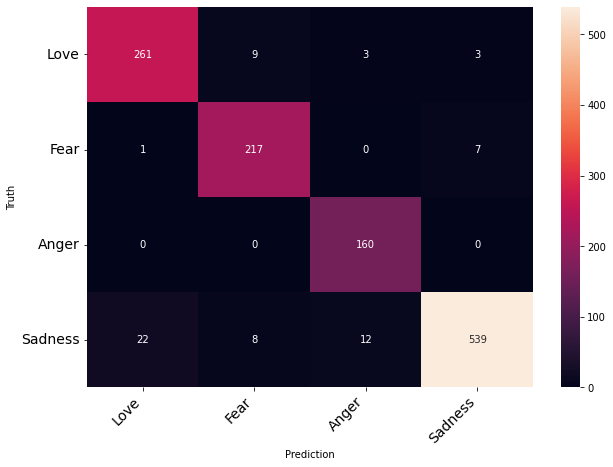

In [ ]:
val = confusion_matrix(true_output,predict_output)  
print_confusion_matrix(val,TestData.keys())

In [ ]:
!transformers-cli login


WARNING! `transformers-cli login` is deprecated and will be removed in v5. Please use `huggingface-cli login` instead.

        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: anirudhovn
Password: 
ERROR:root:HfApi.login: This method is deprecated in favor of `set_access_token`.
Login successful
Your token: MNkgMxJoHFXKkHepacRQcsfTSLZyvZNSFMbeMmIesIjVDdBSgWcuhoPGCQWQhfFfSFEgGVngdgUfVxFlDhrIJvMQUEuysoxMLgIuajJeEhjDeojOEYLbJJTkAyDJrZVy 

Your 

In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,006 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155222 files and directories c

In [ ]:
!git config --global user.email "anirudhovn@gmail.com"

In [ ]:
model.push_to_hub('roberta-base-emotion')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:726: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/anirudhovn/roberta-base-emotion into local empty directory.


Upload file tf_model.h5:   0%|          | 3.38k/476M [00:00<?, ?B/s]

To https://huggingface.co/anirudhovn/roberta-base-emotion
   f477a92..eeb3ecb  main -> main



'https://huggingface.co/anirudhovn/roberta-base-emotion/commit/eeb3ecb4b517bc603308a6103b715edeef7a49c4'

In [ ]:
seqLen = (FormattedTrainData['message'].apply(lambda x: len(x.split())))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


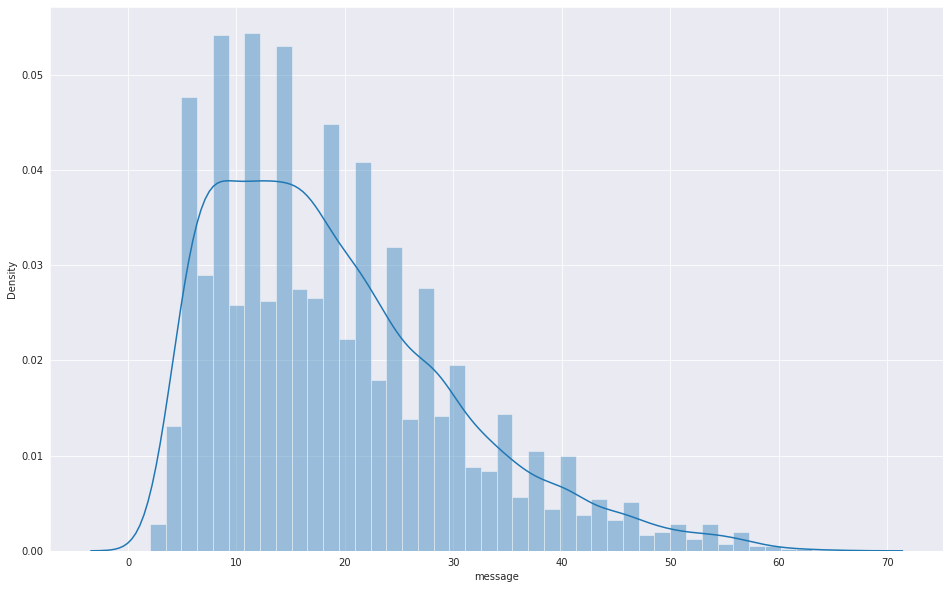

In [ ]:

sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.distplot(seqLen)